In [ ]:
## Import relevant libraries
import os
import glob
import sys
sys.path.append('../../activedrops')

## Including ourselves
import numpy as np
import pivdrops
pivdrops.set_plotting_style()

In [ ]:
from PIL import Image

# Load the uploaded image
image_path = "../../data/03-kif3_nutrients/control/2ul/piv-out/PIVlab_out_001.jpg"
image = Image.open(image_path)

# Convert image to 8-bit pixel format
image = image.convert("L")

# Resize image to 2048x2048
image_resized = image.resize((2048, 2048), Image.LANCZOS)

# Save the processed image
processed_image_path = '../../data/03-kif3_nutrients/control/2ul/piv-out/xxx.jpg'
image_resized.save(processed_image_path)

processed_image_path


In [ ]:
# List of conditions and volumes
# conditions = ['control', 'ATP50nM', 'g6p', 'glucose', 'pep']
# volumes = ['1ul', '2ul', '3ul']

conditions = ['control']
volumes = ['2ul']

# Base directory for data and plots
base_data_dir = "../../data/03-kif3_nutrients"

# Iterate over each condition and volume
for condition in conditions:
    for volume in volumes:
        # Construct the input and output directory paths
        input_dir = f"{base_data_dir}/{condition}/{volume}/piv_data/PIVlab_****.txt"
        output_dir = f"{base_data_dir}/{condition}/{volume}/plots/"
        image_path = f"{base_data_dir}/{condition}/{volume}/original/"  

        # Process the PIV files
        dataframes = pivdrops.process_piv_files(input_dir, volume=2, max_frame=10)

        # Generate time series
        df = pivdrops.piv_time_series(dataframes, time_interval_seconds=3)

        # List of feature names to plot
        features_to_plot = ['velocity', 'power', 'distance', 'work']

        # Plot the time series
        for feature in features_to_plot:
            pivdrops.plot_time_series(df, feature, output_dir=output_dir, sigma=0.5)

        pivdrops.generate_heatmaps(dataframes, 'magnitude [um/s]', vmin=0, vmax=10, output_dir_base=output_dir, image_path=image_path) 
        pivdrops.generate_heatmaps(dataframes, 'vorticity [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir, image_path=image_path)
        pivdrops.generate_heatmaps(dataframes, 'divergence [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir, image_path=image_path) 
        pivdrops.generate_heatmaps(dataframes, 'dcev [1]', vmin=0, vmax=250, output_dir_base=output_dir, image_path=image_path) 
        pivdrops.generate_heatmaps(dataframes, 'simple shear [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir, image_path=image_path) 
        pivdrops.generate_heatmaps(dataframes, 'simple strain [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir, image_path=image_path) 
        pivdrops.generate_heatmaps(dataframes, 'vector direction [degrees]', vmin=-180, vmax=180, output_dir_base=output_dir, image_path=image_path) 


In [ ]:
import os
import glob
from PIL import Image

def process_piv_workflow(conditions, volumes, base_data_dir):
    # Function for converting images to 8-bit and resizing
    def convert_images(input_dir, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        for file_name in glob.glob(os.path.join(input_dir, '*.jpg')):
            # Open and convert the image
            image = Image.open(file_name).convert("L")
            image_resized = image.resize((2048, 2048), Image.LANCZOS)
            
            # Save the processed image in TIFF format
            base_file_name = os.path.splitext(os.path.basename(file_name))[0] + '.tif'
            processed_image_path = os.path.join(output_dir, base_file_name)
            image_resized.save(processed_image_path, format='TIFF', compression='tiff_lzw')
    
    # Define vmin and vmax for each feature
    feature_limits = {
        'magnitude [um/s]': (0, 10),
        'vorticity [1/s]': (-0.03, 0.03),
        'divergence [1/s]': (-0.03, 0.03),
        'dcev [1]': (0, 250),
        'simple shear [1/s]': (-0.03, 0.03),
        'simple strain [1/s]': (-0.03, 0.03),
        'vector direction [degrees]': (-180, 180),
    }
    
    # Iterate over conditions and volumes
    for condition in conditions:
        for volume in volumes:
            # Convert images
            input_image_dir = os.path.join(base_data_dir, condition, volume, "piv_movie")
            output_image_dir = os.path.join(base_data_dir, condition, volume, "piv_movie_corrected_size")
            convert_images(input_image_dir, output_image_dir)
            
            # The rest of your implementation
            input_dir = os.path.join(base_data_dir, condition, volume, "piv_data", "PIVlab_****.txt")
            output_dir = os.path.join(base_data_dir, condition, volume, "plots")
            dataframes = pivdrops.process_piv_files(input_dir, volume=2, max_frame=10)
            df = pivdrops.piv_time_series(dataframes, time_interval_seconds=3)

            # Generate heatmaps with the corrected images for each feature
            for feature, (vmin, vmax) in feature_limits.items():
                pivdrops.generate_heatmaps(dataframes, feature, vmin=vmin, vmax=vmax, output_dir_base=output_dir, image_path=output_image_dir)

# Example usage
conditions = ['control']
volumes = ['2ul']
base_data_dir = "../../data/03-kif3_nutrients"

process_piv_workflow(conditions, volumes, base_data_dir)


In [ ]:
import cv2
import os
import re

def sorted_alphanumeric(data):
    """
    Helper function to sort data in human-readable alphanumeric order.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def make_movies_from_features(base_directory, fps):
    # Find all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

    for feature in subdirectories:
        feature_directory = os.path.join(base_directory, feature)
        output_filename = os.path.join(base_directory, f"{feature}.avi")

        # Get all the .jpg files from the feature directory
        images = [img for img in os.listdir(feature_directory) if img.endswith(".jpg")]

        # Sort the images in alphanumeric order
        images = sorted_alphanumeric(images)

        # Read the first image to get the width and height
        frame = cv2.imread(os.path.join(feature_directory, images[0]))
        height, width, layers = frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

        # Loop through all the images and add them to the video
        for image in images:
            frame = cv2.imread(os.path.join(feature_directory, image))
            out.write(frame)

        # Release everything when the job is finished
        out.release()

# Example usage
base_directory = '../../data/01-k401-biotin_strep/500nM/2ul/plots/'
make_movies_from_features(base_directory, 120)  # Adjust 'base_directory' and fps as needed


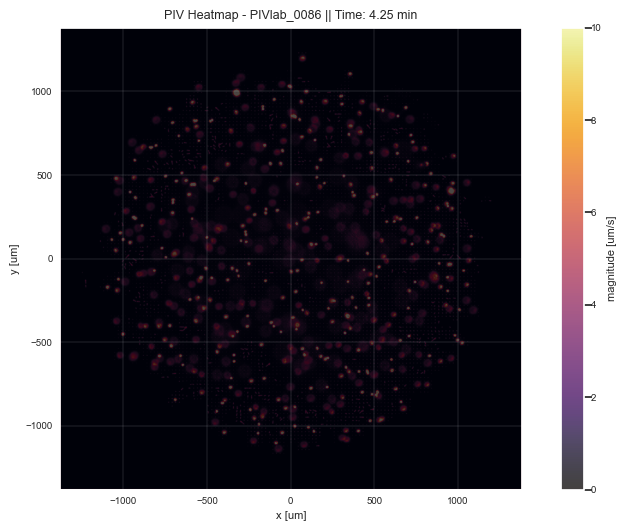

In [2]:
import os
import glob
import sys
import pandas as pd
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()
from natsort import natsorted  # Import for natural sorting
import cv2
import os
import re
from PIL import Image, ImageEnhance, ImageOps  # Added ImageOps here


def sorted_alphanumeric(data):
    """
    Helper function to sort data in human-readable alphanumeric order.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def make_movies_from_features(base_directory, fps):
    # Find all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

    for feature in subdirectories:
        feature_directory = os.path.join(base_directory, feature)
        output_filename = os.path.join(base_directory, f"{feature}.avi")

        # Get all the .jpg files from the feature directory
        images = [img for img in os.listdir(feature_directory) if img.endswith(".jpg")]

        # Skip if no images are found
        if not images:
            print(f"No images found in {feature_directory}, skipping movie creation.")
            continue

        # Sort the images in alphanumeric order
        images = sorted_alphanumeric(images)

        # Read the first image to get the width and height
        frame = cv2.imread(os.path.join(feature_directory, images[0]))
        height, width, layers = frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

        # Loop through all the images and add them to the video
        for image in images:
            frame = cv2.imread(os.path.join(feature_directory, image))
            out.write(frame)

        # Release everything when the job is finished
        out.release()

def save_dataframes(dataframes, output_dir, prefix='df'):
    """Saves a list of DataFrames to the specified directory."""
    dataframes_dir = os.path.join(output_dir, 'dataframes')
    os.makedirs(dataframes_dir, exist_ok=True)

    for i, df in enumerate(dataframes):
        df_path = os.path.join(dataframes_dir, f'{prefix}_{i}.csv')
        df.to_csv(df_path, index=False)

def load_dataframes(output_dir, prefix='df'):
    """Loads DataFrames from the specified directory."""
    dataframes_dir = os.path.join(output_dir, 'dataframes')
    if not os.path.exists(dataframes_dir):
        return None

    df_files = sorted(glob.glob(os.path.join(dataframes_dir, f'{prefix}_*.csv')))
    if not df_files:
        return None

    return [pd.read_csv(df_file) for df_file in df_files]

def convert_images(input_dir, output_dir, max_frame=None, brightness_factor=1, contrast_factor=1):
    """Converts and adjusts images from input_dir and saves them in output_dir."""
    os.makedirs(output_dir, exist_ok=True)
    input_files = natsorted(glob.glob(os.path.join(input_dir, '*.jpg')))

    if max_frame is not None:
        input_files = input_files[:max_frame]

    output_files = natsorted(glob.glob(os.path.join(output_dir, '*.tif')))

    if len(input_files) == len(output_files):
        print(f"Conversion already completed for {output_dir}. Skipping...")
        return

    num_digits = len(str(len(input_files)))

    for i, file_name in enumerate(input_files):
        image = Image.open(file_name).convert("L")
        image_resized = image.resize((2048, 2048), Image.LANCZOS)

        # Adjust brightness
        enhancer = ImageEnhance.Brightness(image_resized)
        image_brightened = enhancer.enhance(brightness_factor)

        # Adjust contrast
        enhancer = ImageEnhance.Contrast(image_brightened)
        image_contrasted = enhancer.enhance(contrast_factor)

        padded_index = str(i + 1).zfill(num_digits)
        base_file_name = f'converted_image_{padded_index}.tif'
        processed_image_path = os.path.join(output_dir, base_file_name)
        image_contrasted.save(processed_image_path, format='TIFF', compression='tiff_lzw')

def combine_timeseries_dataframes(base_data_dir, conditions, subconditions):
    combined_df = pd.DataFrame()

    for condition in conditions:
        for subcondition in subconditions:
            file_path = os.path.join(base_data_dir, condition, subcondition, 'plots', 'dataframes', 'timeseries_df_0.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['Condition'] = f'{condition} {subcondition}'
                combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df


def process_piv_workflow(conditions, subconditions, base_data_dir, max_frame=None, volume_ul=2, brightness_factor=0.8, contrast_factor=0.8):
    """Main workflow to process PIV data."""

    feature_limits = {
        'magnitude [um/s]': (0, 10),
        'vorticity [1/s]': (-0.03, 0.03),
        'divergence [1/s]': (-0.03, 0.03),
        'dcev [1]': (0, 250),
        'simple shear [1/s]': (-0.03, 0.03),
        'simple strain [1/s]': (-0.03, 0.03),
        'vector direction [degrees]': (-180, 180),
    }
    
    for condition in conditions:
        for subcondition in subconditions:
            # Define directories
            input_image_dir = os.path.join(base_data_dir, condition, subcondition, "piv_movie")
            output_image_dir = os.path.join(base_data_dir, condition, subcondition, "piv_movie_8bit_2048x2048")
            output_dir = os.path.join(base_data_dir, condition, subcondition, "plots")

            # Convert images if not already done
            convert_images(input_image_dir, output_image_dir, max_frame, brightness_factor, contrast_factor)

            # Process PIV files if not already done
            dataframes_path = os.path.join(output_dir, 'dataframes', 'df_0.csv')
            if not os.path.exists(dataframes_path):
                input_dir = os.path.join(base_data_dir, condition, subcondition, "piv_data", "PIVlab_****.txt")
                dataframes = pivdrops.process_piv_files(input_dir, volume=volume_ul, max_frame=max_frame)
                # save_dataframes(dataframes, output_dir)
            else:
                dataframes = [pd.read_csv(dataframes_path)]

            # Process time series data if not already done
            timeseries_df_path = os.path.join(output_dir, 'dataframes', 'timeseries_df_0.csv')
            if not os.path.exists(timeseries_df_path):
                df = pivdrops.piv_time_series(dataframes, time_interval_seconds=3)
                save_dataframes([df], output_dir, prefix='timeseries_df')
            else:
                df = pd.read_csv(timeseries_df_path)

            # Plot time series for each feature
            combined_df = combine_timeseries_dataframes(base_data_dir, conditions, subconditions)

            # Plot combined time series data
            for feature in ['velocity', 'power', 'distance', 'work']:
                pivdrops.plot_combined_time_series(combined_df, feature, sigma=1, output_dir=output_dir)  # Specify output_dir if needed

            # Generate heatmaps for each feature
            for feature, (vmin, vmax) in feature_limits.items():
                pivdrops.generate_heatmaps(dataframes, feature, vmin=vmin, vmax=vmax, output_dir_base=output_dir, image_path=output_image_dir)

            # Make movies
            make_movies_from_features(output_dir, fps=120)

                

# Example usage
conditions = ['k401']
volumes = ['rep1']
base_data_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
process_piv_workflow(conditions, volumes, base_data_dir, max_frame=200, volume_ul=2)
